# Содержание:
* [Предварительное исследование и предобработка данных](#Предварительное-исследование-и-предобработка-данных)
* [Выбор метрик и анализ:](#Выбор-метрик)
    * [Конверсия](#Конверсия-(Conversion-Rate))
    * [Средний чек](#Средний-чек-(Average-order-value))
* [Вывод](#Вывод)


In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels
from scipy import stats  
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import norm 
plt.style.use('ggplot')
from statsmodels.stats.power import TTestIndPower

## Условие <a class="anchor" id="Задание-1.-A/B–тестирование"></a>
**_В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей._**

**_В качестве входных данных мы имеем 4 csv-файла:_**
* **_groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)_** 
* **_groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных_**
* **_active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента._** 
* **_checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента._** 


### Предварительное исследование и предобработка данных <a class="anchor" id="Предварительное-исследование-и-предобработка-данных"></a>

In [2]:
# Прочитали полученные файлы с данными:
groups = pd.read_csv('https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_groups.csv', sep=';') 
groups_add = pd.read_csv('https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_group_add.csv') 
active = pd.read_csv('https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_active_studs.csv')
checks = pd.read_csv('https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_checks.csv', sep=';')

In [3]:
# Проверим количество пропущенных и уникальных значений в данных
groups.info()
print("\n", groups['id'].nunique(), "уникальных id")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB

 74484 уникальных id


In [4]:
groups_add.info()
print("\n", groups_add['id'].nunique(), "уникальных id")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB

 92 уникальных id


In [5]:
active.info()
print("\n", active['student_id'].nunique(), "уникальных id")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB

 8341 уникальных id


In [6]:
checks.info()
print("\n", checks['student_id'].nunique(), "уникальных id")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB

 541 уникальных id


**_Пропущенных значений нет, количество строк совпадает с количеством уникальных id, следовательно id внутри таблиц не повторяются_**

In [7]:
# Проверим количество пользователей в тестовой и контрольной группах
groups.groupby('grp', as_index=False)['id'].count()

,grp,id
0,A,14671
1,B,59813


In [8]:
# Размер групп в процентном соотношении к общему количеству пользователей
round(groups['grp'].value_counts(normalize=True), 2)

B    0.8
A    0.2
Name: grp, dtype: float64

**_Количество пользователей в тестовой группе больше, чем в контрольной, пропорция 20/80.
<br>При проведении A/B теста, группы могут отличаться количеством пользователей, но при этом иметь одинаковое распределение трафика. Нужно иметь ввиду, что для сравнения групп между собой нужно использовать метрики относительно размера семпла,а не абсолютные.
<br>Также нужно учитывать, что при пропорции 20/80, чтобы достичь мощности теста 80%, размер общей выборки должен быть больше чем при пропорции 50/50_**

In [9]:
# Объединим данные сплитования, активности и оплаты в один датасет
# Добавили признак активности (1 - активный, 0 - неактивный)
groups['active'] = np.where(groups['id'].isin(active['student_id']) == True, 1, 0)

# Добавили сумму чека
checks = checks.rename(columns={'student_id': 'id'})
df = groups.merge(checks[['id', 'rev']], on='id', how='left')
df['rev'] = round(df['rev'].fillna(0), 2)
display(df.head())

df.shape

,id,grp,active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


(74484, 4)

In [10]:
# Проверим все ли активные и оплатившие пользователи просплитовались
print(len(active) - len(df.query('active == 1')), "активных пользователей не просплитовались на группы")
print(len(checks) - len(df[df['rev'] != 0]), "заплативших пользователей не просплитовались на группы")

13 активных пользователей не просплитовались на группы
1 заплативших пользователей не просплитовались на группы


In [11]:
# Проверим какие именно активные студенты не попали в сплитование 
active[~active['student_id'].isin(df['id'])]

,student_id
1,5723133
111,5951797
632,5730382
2662,5739944
3830,5945085
4900,5700613
5254,5729371
5746,5777081
7413,5740903
7505,5760471


In [12]:
# Проверим какие именно оплатившие студенты не попали в сплитование 
checks[~checks['id'].isin(df['id'])]

,id,rev
540,5740903,1900.0


In [13]:
# Дополним данные сплитования файлом, полученным через 2 дня
uni_groups = pd.concat([groups, groups_add])  # объединили датафреймы
print(uni_groups.shape[0], 'размер дополненного датафрейма') 
print(uni_groups['id'].nunique(), "уникальных id") 
print(len(uni_groups) - len(df), 'id добавлено')  # проверка


74576 размер дополненного датафрейма
74576 уникальных id
92 id добавлено


In [14]:
# Объединим данные сплитования, активности и оплаты в один датасет
# Добавили признак активности (1 - активный, 0 - неактивный)
uni_groups['active'] = np.where(uni_groups['id'].isin(active['student_id']) == True, 1, 0)
# Добавили сумму оплаты
checks = checks.rename(columns={'student_id': 'id'})
user_data = uni_groups.merge(checks[['id', 'rev']], on='id', how='left')
user_data['rev'] = round(user_data['rev'].fillna(0), 2)
# Проверим все ли пользователи из таблиц активности и оплаты присуствуют в таблице сплитования на группы
print(len(active) - user_data.query('active == 1').shape[0], "активных пользователей не просплитовались на группы")
print(len(checks) - len(user_data[user_data['rev'] != 0]), "заплативших пользователей не просплитовались на группы")

0 активных пользователей не просплитовались на группы
0 заплативших пользователей не просплитовались на группы


In [15]:
# Количество пользователей после добавления доп.данных
user_data.groupby('grp', as_index=False)['id'].count()

,grp,id
0,A,14693
1,B,59883


In [16]:
# После добавления доп. данных размер групп в процентном соотношении не изменился
round(user_data['grp'].value_counts(normalize=True), 2)

B    0.8
A    0.2
Name: grp, dtype: float64

**_После преобразования таблиц, в итоге получены следующие данные:_**
* **_74484 пользователя попали в выборку для проведения эксперимента_**
* **_8341 пользователь входил на платформу в период проведения эксперимента (информация о времени проведения эксперимента отсутствует)_**
* **_541 пользователь совершил покупку (информация о времени совершении покупки отсутствует)_**
* **_92 пользователя добавлены в группу для проведения эксперимента, информация получена спустя 2 дня_**
* **_14693 пользователя в контрольной группе/59883 пользователя в тестовой (20/80)_**

**_Пользователей можно сгруппировать по двум признакам - активность и платеж, получится 4 типа: активный и купивший, активный и некупивший, неактивный и купивший, неактивный и некупивший_**

In [17]:
def get_group(active, rev):
    '''Функция для присвоения группы по признакам активности и платежа'''
    if active == 1:
        if rev > 0:
            return "активный и купивший"
        else:
            return "активный и некупивший"
    elif active == 0:
        if rev > 0:
            return "неактивный и купивший"
        else:
            return "неактивный и некупивший"
    else:
        return active
    
    
user_data['group_type'] = pd.Series(map(get_group, df['active'], df['rev']))
user_data.head()

,id,grp,active,rev,group_type
0,1489,B,0,0.0,неактивный и некупивший
1,1627,A,1,990.0,активный и купивший
2,1768,B,0,0.0,неактивный и некупивший
3,1783,B,0,0.0,неактивный и некупивший
4,1794,A,0,0.0,неактивный и некупивший


In [18]:
# тестовая и контрольная группа по типам признака
count_types = user_data.groupby('grp')['group_type'].value_counts()\
    .to_frame()\
    .rename(columns={'group_type': 'users'})\
    .reset_index()
count_types

,grp,group_type,users
0,A,неактивный и некупивший,13107
1,A,активный и некупивший,1457
2,A,активный и купивший,78
3,A,неактивный и купивший,29
4,B,неактивный и некупивший,52900
5,B,активный и некупивший,6480
6,B,активный и купивший,313
7,B,неактивный и купивший,120


In [19]:
# Количество активных и неактивных пользователей только среди чеков
only_paid = user_data[user_data['rev'] != 0]
payment_percent = only_paid.groupby('grp')['group_type']\
    .value_counts(normalize=True).to_frame()\
    .rename(columns={'group_type': 'users'})\
    .reset_index()\
    .rename(columns={'users': 'percent_of_users'})
payment_percent['percent_of_users'] = round(payment_percent['percent_of_users'] * 100, 2)
payment_percent

,grp,group_type,percent_of_users
0,A,активный и купивший,72.90
1,A,неактивный и купивший,27.10
2,B,активный и купивший,72.29
3,B,неактивный и купивший,27.71


**_Среди неактивных пользователей есть оплатившие, около 27% от всех купивших в каждой группе. Поскольку у нас нет данных с датами событий, предположим, что под "купившими" мы понимаем всех, кто начал процесс оплаты. Неактивный и купивший пользователь, попавший в выборку, это пользователь, который не входил на платформу в дни проведения эксперемента и поэтому не подвергался эффекту внесенных изменений в механику оплаты, но начавший процесс покупки ранее._**

In [20]:
# в процентном соотношении состав групп примерно одинаковый
types_percent = user_data.groupby('grp')['group_type']\
    .value_counts(normalize=True).to_frame()\
    .rename(columns={'group_type': 'users'})\
    .reset_index()\
    .rename(columns={'users': 'percent_of_users'})
types_percent['percent_of_users'] = round(types_percent['percent_of_users'] * 100, 2)
types_percent

,grp,group_type,percent_of_users
0,A,неактивный и некупивший,89.34
1,A,активный и некупивший,9.93
2,A,активный и купивший,0.53
3,A,неактивный и купивший,0.20
4,B,неактивный и некупивший,88.44
5,B,активный и некупивший,10.83
6,B,активный и купивший,0.52
7,B,неактивный и купивший,0.20


### Выбор метрик <a class="anchor" id="Выбор-метрик"></a>

**_Целевой группе была предложена новая механика оплаты услуг на сайте. В зависимости от сути этих изменений, новая механика могла повлиять как на количество чеков (новое окно может увеличить или уменьшить конверсию в покупку), так и на сумму чеков (если новая механика влияет на платежеспособность пользователя - оплата по частям, баллами, купонами или в рассрочку может увеличить сумму чека, или если на сайте для оплаты с купоном на скидку механика стала менее понятной для пользователя, то средний чек может умешиться). Поэтому будем рассматривать Конверсию и Средний чек, произведение которых даст нам относительную выручку (Revenue per visitor = Conversion rate * Average Order Value)_**
 
**_Для анализа будем учитывать только активных пользователей, т.е. тех которые заходили на платформу в период проведения экперимента, т.к. на тех пользователей, которые в это время не заходили на платформу, эксперимент не мог повлиять._**

In [21]:
# Данные для расчета метрик
active_users = user_data.query('active == 1')\
    .groupby('grp', as_index=False)\
    .agg(amount_active_users=('id', 'count'))
check_users = user_data.query('active == 1 & rev > 0')\
    .groupby('grp', as_index=False)\
    .agg(amount_check_users=('id', 'count'), rev_check=('rev', 'sum'))
metrics_df = active_users.merge(check_users, on='grp', how='left')
metrics_df

,grp,amount_active_users,amount_check_users,rev_check
0,A,1538,78,72820.0
1,B,6803,314,394974.0


***
#### Конверсия (Conversion Rate) <a class="anchor" id="Конверсия-(Conversion-Rate)"></a>

**_У конверсии биномиальный тип данных, т.е. данные могут принимать только два значения "да/нет", "успех"(1) или "неудача"(0). Биномиальное распределение не является нормальным. Однако согласно Центральной предельной теореме независимо от формы распределения популяции, из которой мы берем выборки, распределение выборочных средних будет распределено нормально, относительно среднего выборочных средних, которое будет приблизительно равно среднему популяции. А дисперсия выборки будет  приблизительно равной дисперсии популяции, при условии большого размера выборки. Поэтому, предполагается, что она известена, несмотря на то, что у нас есть только выборочные данные. Поэтому для тестирования гипотез о схожести пропорций можно использовать Z-тест_**

**Сформулируем гипотезы и расчитаем конверсию**

**_Конверсия(CR) = Количество покупателей/Количество пользователей_**

**_Н0: CR_B = CR_A (Конверсия контрольной и тестовой групп не имеет существенных различий)
<br>H1: CR_B != CR_A (Конверсии контрольной и тестовой групп стат.значимо различаются)_**

In [22]:
metrics_df['CR'] = metrics_df['amount_check_users'] / metrics_df['amount_active_users']
display(metrics_df[['grp', 'CR', 'amount_check_users', 'amount_active_users']])
CR_A = float(metrics_df.query('grp == "A"')['CR'])
CR_B = float(metrics_df.query('grp == "B"')['CR'])
CR_diff = CR_B - CR_A
print("CR difference = ", CR_diff)

,grp,CR,amount_check_users,amount_active_users
0,A,0.050715,78,1538
1,B,0.046156,314,6803


CR difference =  -0.004559106964780894


**_Конверсия в тестовой группе ниже чем в контрольной._**

**_Для проверки гипотезы о равенстве конверсий будем использовать z-тест пропорций_**

In [23]:
successes = np.array(metrics_df['amount_check_users'])
user_amount = np.array(metrics_df['amount_active_users'])
test_stat, p_value = proportions_ztest(successes, user_amount, alternative='two-sided')
print("stat", test_stat)
print("p_value", p_value)

stat 0.7629884495263746
p_value 0.445470284371589


**_Результаты проведенного теста не позволяют нам отвергнуть нулевую гипотезу о том, что конверсии двух групп одинаковы. Вероятность получить такую разницу в конверсии при том, что нулевая гипотеза верна составляет 44%
<br>Однако есть вероятность совершить ошибку второго рода - не отклонить нулевую гипотезу, хотя альтернативная была верна._**

**_Определим статистическую мощность теста гипотезы и верояность совершить ошибку второго рода_**

In [24]:
# Анализ мощности
diff = CR_diff
prop2 = CR_A 
prop1 = prop2 + diff
nobs1 = 6803
statsmodels.stats.proportion.power_proportions_2indep\
    (diff, prop2, nobs1, 1538 / 6803, alternative='two-sided', return_results=True)

<class 'statsmodels.tools.testing.Holder'>
power = 0.12632422072570523
p_pooled = 0.046996762978060186
std_null = 0.49284692777926165
std_alt = 0.5069283463066417
nobs1 = 6803
nobs2 = 1538.0
nobs_ratio = 0.22607673085403499
alpha = 0.05

**_Анализ показывает, что мощность теста низкая, около 13%. Рекомендуемая мощность не ниже 80%, т.е. вероятность совершить ошибку 2 рода должна составлять 20%. В нашем случае такая верояность высокая 87% (1-0.12632422072570523 = 0.8736757792742947).
<br> Увеличить мощность теста можно увеличив размер выборки._**

**_Расчитаем необходимый размер выборки, учитывая полученный результат, но со статистической силой в 80%_**

In [25]:
diff = CR_diff
prop2 = CR_A 
prop1 = prop2 + diff
power = 0.8
statsmodels.stats.proportion.samplesize_proportions_2indep_onetail(diff, prop2, power, ratio=1538 / 6803, alpha=0.05, value=0, alternative='two-sided')

93303.00767638293

In [26]:
# необходимый размер контрольной группы
(1538 / 6803) * 93303.00767638293

21093.638954325583

**_т.е. при разнице на 0.004 (8% от контроля) между тестовой и контрольной группами, и при такой же пропорции, нам нужно иметь 11167 пользователей в контрольной группе и 49393 в тестовой, чтобы быть уверенными, что разница в нашем случае стат.НЕзначима, что мы не отклоним нулевую гипотезу с минимальной вероятностью совершить ошибку второго рода._**

**_На данный момент прийти к выводу, что новая мехника не влият на конверсию мы не можем, требуется собрать больше наблюдений_** 

***
#### Средний чек (Average order value) <a class="anchor" id="Средний-чек-(Average-order-value)"></a>

**_Средний чек(AOV) = Доход/Количество чеков_**

**_Так как id в таблице с чеками не повторяются, предположим, что каждый пользователь сделал только один заказ, и в таблице заказы не просуммированы. Один пользователь = Один чек._**

**_Н0: AOV_B = AOV_A (Средний чек контрольной и тестовой групп не имеет существенных различий)
<br>H1: AOV_B != AOV_A (Средний чек контрольной и тестовой групп стат.значимо различается)_**

In [27]:
metrics_df['AOV'] = metrics_df['rev_check'] / metrics_df['amount_check_users']
display(metrics_df[['grp', 'AOV', 'amount_check_users', 'rev_check']])
AOV_A = float(metrics_df.query('grp == "A"')['AOV'])
AOV_B = float(metrics_df.query('grp == "B"')['AOV'])
print("AOV difference = ", AOV_B - AOV_A)

,grp,AOV,amount_check_users,rev_check
0,A,933.589744,78,72820.0
1,B,1257.878981,314,394974.0


AOV difference =  324.2892373019762


**_Сумма среднего чека тестовой группы больше среднего чека контрольной группы_**

In [28]:
# посмотрим на распределение чеков
A_checks = user_data.query('grp == "A" & active == 1 & rev > 0')
B_checks = user_data.query('grp == "B" & active == 1 & rev > 0')

C:\Users\iTMaster_PC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


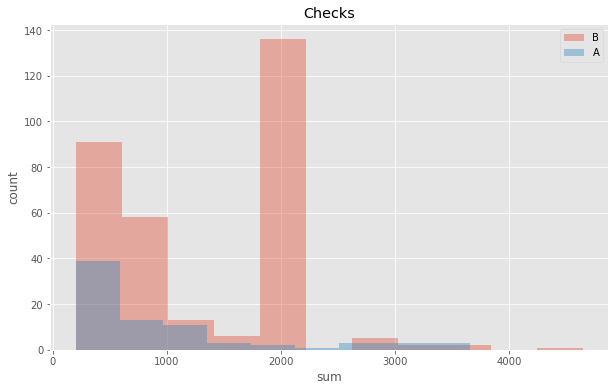

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(ylabel='count', title='Checks')
sns.distplot(B_checks['rev'], label="B", axlabel='sum', kde=False)
sns.distplot(A_checks['rev'], label="A", axlabel='sum', kde=False)
plt.legend()

In [30]:
B_checks['rev'].value_counts().head(3)

1900.0    128
290.0      45
199.0      27
Name: rev, dtype: int64

**_На гистограмме видно, что количество чеков в контрольной группе ниже, чем в тестовой из-за разницы в размере выборок. Кроме того в контрольной группе существует зависимость, чем выше цена тем меньше количество чеков на эту сумму. В распределении тестовой группы в целом тоже присутствет такая зависимость, за исключением чека на 1900.
<br>Возможно на 128 пользователей с чеком 1900 могло действовать еще какое-то изменение, кроме новой механики оплаты. Например эти пользователи могли попасть в группу другого теста, где проверялось влияние акции - при покупке курса стоимостью 1900, на второй курс скидка. На 128 пользователях могли проводить сразу 2 экперимента.
<br>Другой вариант, возможно сама тема продаваемого курса по каким-то причинам могла стать мега популярной, из-за чего случился аномальный скачок количества продаж именно этого курса стоимостью 1900. То есть скачок продаж отдельного товара можно объяснить модой или сезоном. 
<br>Для определения природы этой аномалии требуется больше данных, на данном этапе информация о 128 пользователях совершивших покупку на 1900 может исказить результаты теста.
<br> При этом 128 пользователей это 40% от всей нашей выборки чеков в тестовой группе, т.е. мы не можем полагаться на достоверность почти половины наблюдений в тестовой выборке._**  

In [31]:
# посмотрим есть ли чек 1900 в контрольной группе
A_checks['rev'].unique()

array([ 990., 1830., 2910., 2820., 3660.,  580., 2900., 1980.,  290.,
       1160., 1530.,  398.,  690., 1140.,  840.,  199.,  489.,  590.,
       2220., 1180., 2890., 1039.,  870.])

In [32]:
# Посмотрим чеки неактивных пользователей
B_checks_past = user_data.query('grp == "B" & active == 0 & rev > 0')
B_checks_past['rev'].value_counts().head(5)

690.0     46
290.0     18
990.0     18
199.0     12
1140.0    11
Name: rev, dtype: int64

C:\Users\iTMaster_PC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


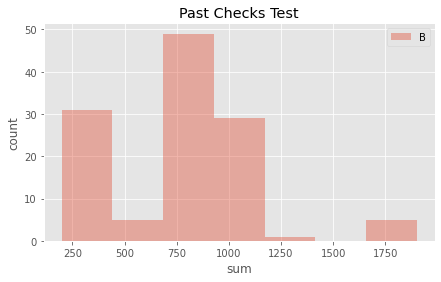

In [33]:
# Распределение чеков неактивных пользователей тестовой группы
fig, ax = plt.subplots(figsize=(7, 4))
ax.set(ylabel='count', title='Past Checks Test')
sns.distplot(B_checks_past['rev'], label="B", axlabel='sum', kde=False)
plt.legend()

**_Чек 1900 отсутсвует в контрольной группе. В платежах совершенных в прошлом, выбросов по чеку на 1900 нет, но данных мало. Поскольку нам неизвестна природа резкого роста количества чеков на 1900 и нет данных для его детального исследования, удалим 128 пользователей с чеком 1900 из тестовой группы. И проведем сравнение контрольной и тестовой группы с чеком 1900 и без него._**

In [34]:
# откорректированная тестовая группа без учета чека на 1900
new_B_checks = B_checks.query('rev != 1900')
len(B_checks) - len(new_B_checks)

128

In [35]:
# Сравним средний чек новой тествой и контрольной групп
AOV_new_B = new_B_checks['rev'].sum() / new_B_checks['active'].sum()
print(AOV_new_B)
print(AOV_A)
AOV_new_B - AOV_A

815.989247311828
933.5897435897435


-117.60049627791557

**_Без учета чека на 1900, средний чек тестовой группы ниже среднего чека контрольной_**

C:\Users\iTMaster_PC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


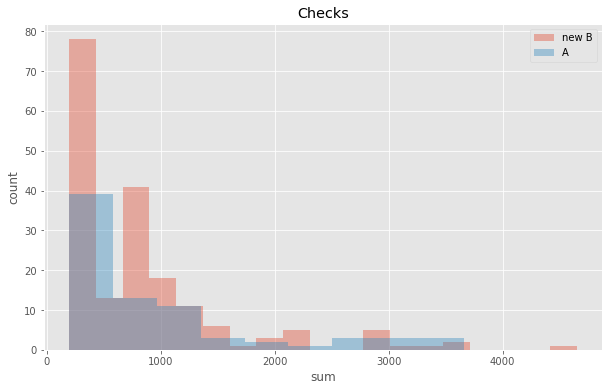

In [36]:
# Распределение чеков контольной и новой тестовой групп
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(ylabel='count', title='Checks')
sns.distplot(new_B_checks['rev'], label="new B", axlabel='sum', kde=False)
sns.distplot(A_checks['rev'], label="A", axlabel='sum', kde=False)
plt.legend()

In [37]:
# Сравним описательные статистики.
new_B_checks['rev'].describe()

count     186.000000
mean      815.989247
std       759.354199
min       199.000000
25%       290.000000
50%       690.000000
75%       990.000000
max      4650.000000
Name: rev, dtype: float64

In [38]:
A_checks['rev'].describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [39]:
B_checks['rev'].describe()

count     314.000000
mean     1257.878981
std       790.864245
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

**_В результате удаления данных по чеку 1900 описательные статистики тестовой группы значительно изменились и стали больше приближены к статистикам контрольной группы. Изначально средние и медианы отличались в 1.5-2 раза, после удаления разница между средним, медианой и 3-м процентилем сократилась, 1-й процентиль совпадает._**

In [40]:
# Проверка на нормальность распределения тестом Шапиро-Уилка 
scipy.stats.shapiro(A_checks['rev'])

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [41]:
scipy.stats.shapiro(B_checks['rev'])

ShapiroResult(statistic=0.854723334312439, pvalue=1.5436537542021223e-16)

In [42]:
scipy.stats.shapiro(new_B_checks['rev'])

ShapiroResult(statistic=0.740757942199707, pvalue=9.010076071890185e-17)

**_Тест Шапиро-Уилка проверяет гипотезу о том, что выборка изъята из генеральной совокупности, где распределение признака соответствует нормальному. В наших контрольной, тестовой и откорректированной тестовой выборках р-уровень значимости намного меньше 0.05, распредление групп значимо отличается от нормального._**

**_Для сравнения средних чеков будем использовать T-тест, который предполагает, что значения выборочных средних должны быть распределены нормально и размер выборки должен быть большой. Согласно Центральной предельной теореме, распределение выборочных средних будет стремиться к нормальному даже при ненормальном распределении признака в генеральной совокупности. То есть T-тест действителен на выборке большого размера с ненормальным распределением признака, однако если выборка небольшая требуется, чтобы распределение признака было приблизительно нормальным._**

**_Так как размеры выборок не равны применим t-критерий Уэлча_**

In [43]:
stats.ttest_ind(A_checks['rev'], new_B_checks['rev'], equal_var=False)

Ttest_indResult(statistic=0.9956924829142738, pvalue=0.32135267998140593)

In [44]:
stats.ttest_ind(A_checks['rev'], B_checks['rev'], equal_var=False)

Ttest_indResult(statistic=-2.861689662002993, pvalue=0.005069735402824095)

**_Сравнение средних чеков контрольной и тестовой группы показало, что вероятность получить различие на 324(34,73%) при том, что нулевая гипотеза верна составляет менее 5%. Разница стат.значима. 
Сравнение средних чеков после исключения пользователей с чеками 1900 показало, что вероятность получить различие на 117(12,59%) при том, что нулевая гипотеза верна, довольно большая 32%._**  

**_Поведенный анализ приводит к выводу о том, что именно аномальный скачок количества чеков на 1900 дал значимый прирост прибыли. Без его учета тест не дает значимых результатов. Поскольку нам неизвестна природа этого выброса, результаты теста очень сомнительны относительно предмета нашего эксперимента - новой механики оплаты. Логично предположить, что тестируемое нами изменение механики оплаты не могло повлиять только на один отдельный вид чека. Такое изменение должно было повлиять на все виды чеков примерно в одинаковой степени. Скорее всего на прирост прибыли в тестовой группе повлиял другой неизвестный нам фактор (другой тест, сезон, мода)._**   

**_Результат сравнения средних чеков контрольной и откорректированной тестовой групп, без учета чека 1900, показывает, что у нас нет достаточных оснований отвергнуть нулевую гипотезу._**

**_Расчитаем вероятность совершить ошибку второго рода и определимм достаточное ли у нас количество наблюдений, после того как мы удалили аномальные наблюдения, чтобы быть уверенным в том, что разница между контрольной и откорректированной тестовой группой статистически незначима._**

**_Для этого расчитаем эффект с помощью стандартизированной средней разницы d Коэна_**

In [45]:
def calc_cohen_d(group1, group2):
    """фукнция для расчета d Коэна"""
    
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2) 
    d = diff / np.sqrt(pooled_var)
    
    return d

In [46]:
cohens_d = calc_cohen_d(A_checks['rev'], new_B_checks['rev'])
abs(cohens_d)

0.14516474681302935

**_Средние значения двух групп отличаются на 0.14 стандартных отклонения - низкий размер эффекта._**

In [47]:
cohens_d_1 = calc_cohen_d(A_checks['rev'], B_checks['rev'])
abs(cohens_d_1)

0.39635900758859843

In [48]:
# Мощность теста
TTestIndPower().solve_power(0.2, nobs1=78, ratio=186 / 78, alpha=0.05, alternative='two-sided')

0.3149232611478454

**_Стат мощность теста низкая, около 31%, вероятность совершить ошибку 2 рода 69%._** 

In [49]:
# Необходимый размер первой выборки при мощности теста 80%
TTestIndPower().solve_power(0.2, power=0.8, nobs1=None, ratio=186 / 78, alpha=0.05, alternative='two-sided')

279.0765790786379

In [50]:
# Размер второй выборки
279.07657907863677 * (186 / 78)

665.4903039567492

**_Для того чтобы увеличить мощность теста до 80% при той же пропорции и уменьшить вероятность совершить ошибку второго рода, нужно чтобы размер контрольной группы был 279 чеков, а тестовой 665._**

### Вывод  <a class="anchor" id="Вывод"></a>

**_Целью исследования было определить влияет ли новая механика оплаты на выручку компании. Для этого было проведено сравнение между контрольной и тестовой группой по двум метрикам - конверсия и средний чек и были сделаны следующие наблюдения:_**

* **_Сравнение конверсий двух групп показало, что оснований утверждать, что разница стат.значима нет._** 

* **_В данных об оплате был обнаружен аномальный рост количества чеков на сумму 1900. Возможно на наблюдения, выбранные для экперимента по влиянию новой механики оплаты, оказывал действие другой эксперимент, проводимый в компании. Произошло пересечение между наблюдениями двух экпериментов._**  
* **_Без учета аномальных данных сравнение среднего чека по двум группам не дало стат.значимого результата_**
* **_На основании полученных данных мы не можем утверждать, что существует разница между двумя группами, однако, по обеим метрикам, недостаточное количество полученных данных не дает нам утверждать, что разницы действительно нет._** 

**_Для получения более точных результатов, при дизайне экперимента нужно было учесть, что для использования несбалансированного теста требуется иметь достаточный объем трафика для обнаружения интересующих изменений в метрике и чем больше это изменение(например 20% и выше), тем больше вероятность его обнаружить. 
В нашем случае зафиксированные изменения очень маленькие, при балансе 20/80 не хватает трафика для достижения мощности теста 80%. Если ожидаемый прирост или падение метрики достаточно маленькие (допустим, меньше 5%), то для достижения необходимой мощности теста можно придерживаться баланса 50/50._** 

**_Следует ли запускать новую механику оплаты на всех пользователей?
<br>На данном этапе - нет. У нас нет уверенности в достоверности полученных данных, требуется больше наблюдений для эксперимента. Результат запуска новой механики оплаты на всех пользователей на данном этапе непредсказуем. Мы можем получить как положительный так и отрицательный эффект, либо получить очень незначительный эффект, который не превысит стоимости затраченных ресурсов на внедрение новой механики оплаты на всех пользователей._**    
